[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/00_preprocesamiento_dataset_clasificacion.ipynb)



# Preparación y preprocesamiento de datos del dataset Ninapro DB1

## Objetivo a desarrollar

> Obtener del dataset crudo los datos, combinarlos y realizar una transformación simple para hacerlos aptos para el entrenamiento de los modelos a emplear.

## 1. Librerias y configuraciones previas


In [1]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import mlflow
    print("La librería 'mlflow' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'mlflow' no está instalada.")
    print("Instalando 'mlflow'...")
    !pip install mlflow

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'mlflow' está instalada y se ha importado correctamente.


In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal


In [3]:
import requests
from tqdm import tqdm
import os
import zipfile
import sys

In [4]:
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor

## 2. Funciones

In [5]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
# from utils.funciones1 import multiple_plot
# from utils.funciones2 import test_hola, graficar_medida, graficar_medida2, filter_signal, \
#                             segmentar_data_base, aplanar_data_base, aplanar_ventana, \
#                             rms_value, mav_value, features_data_base

def find_value_ranges(arr, value):
    """
    Encuentra los rangos (inicio, fin) donde el valor dado aparece de forma continua en un array.

    Parámetros:
        arr (array-like): arreglo de entrada (lista o np.array).
        value (int o float): valor objetivo para encontrar bloques contiguos.

    Retorna:
        List[Tuple[int, int]]: lista de tuplas (inicio, fin) donde aparecen bloques del valor.
    """
    arr = np.asarray(arr)
    ranges = []
    in_range = False

    for i, val in enumerate(arr):
        if val == value and not in_range:
            start = i
            in_range = True
        elif val != value and in_range:
            end = i - 1
            ranges.append((start, end))
            in_range = False

    # Si termina en un bloque del valor
    if in_range:
        ranges.append((start, len(arr) - 1))

    return ranges

## 3. Carga y preprocesamiento del dataset original

Configuración inicial

In [9]:
# Agregar el directorio raíz del proyecto al PYTHONPATH
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Sube un nivel
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
print(f"Directorio raíz del proyecto agregado al PYTHONPATH: {ROOT_DIR}")

Directorio raíz del proyecto agregado al PYTHONPATH: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia


In [10]:
# se importan las rutas
# from globals import SRC_DIR, DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR
# Agregar el directorio SRC_DIR al PYTHONPATH
#if SRC_DIR not in sys.path:
#    sys.path.append(SRC_DIR)
from globals import RAW_SUBSET_DATA_DIR
print(f"Ruta de subconjunto de datos crudos: {RAW_SUBSET_DATA_DIR}")

Ruta de subconjunto de datos crudos: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset


### Formato del archivo

Con el fin de conocer un poco lo que contiene un solo MAT vamos a realizar los siguientes procedimientos.

En nuestro analisis, solo nos va a interesar los datos de las columnas:
* **`emg`**: Señales EMG superficiales tomadas de los 10 electronos.
* **`rerepetition`**: Repetición de la postura de la mano (ejercicio) realizado. Cada postura se repetira 10 veces.
* **`restimulus`**: Postura manual (ejercicio) realizada.

### Carga de datos

### Combinación de los archivos

In [23]:
# Listar y cargar los archivos .npy del directorio PROCESSED_DATA_DIR
npy_files = [f for f in os.listdir(RAW_SUBSET_DATA_DIR) if f.endswith('.npy')]

raw_data = {}
for file in npy_files:
    file_path = os.path.join(RAW_SUBSET_DATA_DIR, file)
    sub_i = file.split('_s')[-1].split('.')[0]
    sub_i = sub_i.split('_')[0]
    raw_data[sub_i] = np.load(file_path)
    print(f"Archivo cargado: {file}")

Archivo cargado: raw_subset_s10_p1_23_E3.npy
Archivo cargado: raw_subset_s11_p1_23_E3.npy
Archivo cargado: raw_subset_s12_p1_23_E3.npy
Archivo cargado: raw_subset_s13_p1_23_E3.npy
Archivo cargado: raw_subset_s14_p1_23_E3.npy
Archivo cargado: raw_subset_s15_p1_23_E3.npy
Archivo cargado: raw_subset_s16_p1_23_E3.npy
Archivo cargado: raw_subset_s17_p1_23_E3.npy
Archivo cargado: raw_subset_s18_p1_23_E3.npy
Archivo cargado: raw_subset_s19_p1_23_E3.npy
Archivo cargado: raw_subset_s1_p1_23_E3.npy
Archivo cargado: raw_subset_s20_p1_23_E3.npy
Archivo cargado: raw_subset_s21_p1_23_E3.npy
Archivo cargado: raw_subset_s22_p1_23_E3.npy
Archivo cargado: raw_subset_s23_p1_23_E3.npy
Archivo cargado: raw_subset_s24_p1_23_E3.npy
Archivo cargado: raw_subset_s25_p1_23_E3.npy
Archivo cargado: raw_subset_s26_p1_23_E3.npy
Archivo cargado: raw_subset_s27_p1_23_E3.npy
Archivo cargado: raw_subset_s2_p1_23_E3.npy
Archivo cargado: raw_subset_s3_p1_23_E3.npy
Archivo cargado: raw_subset_s4_p1_23_E3.npy
Archivo cargad

In [24]:
len(raw_data)  # Mostrar la cantidad de archivos cargados

27

In [25]:
raw_data['1'].shape

(16036, 12)

### Usuario de muestra

Nuevamente usemos el usuario de muestra 1 (indice = 0)

```
[ emg | restimulus | rerepetition ] = [ 0:9 | 10 | 11 ]
```

* **`restimulus`**: 1 - 23 (El reposo se toma como 0)
* **`rerepetition`**: 1 - 10

In [30]:
INDEX_SUB = '1'
emg_s1 = raw_data[INDEX_SUB][:,0:10]
restimulus_s1 = raw_data[INDEX_SUB][:,10]
rerepetition_s1 = raw_data[INDEX_SUB][:,11]

Vamos a graficar todas los ejercicios para el usuario seleccionado

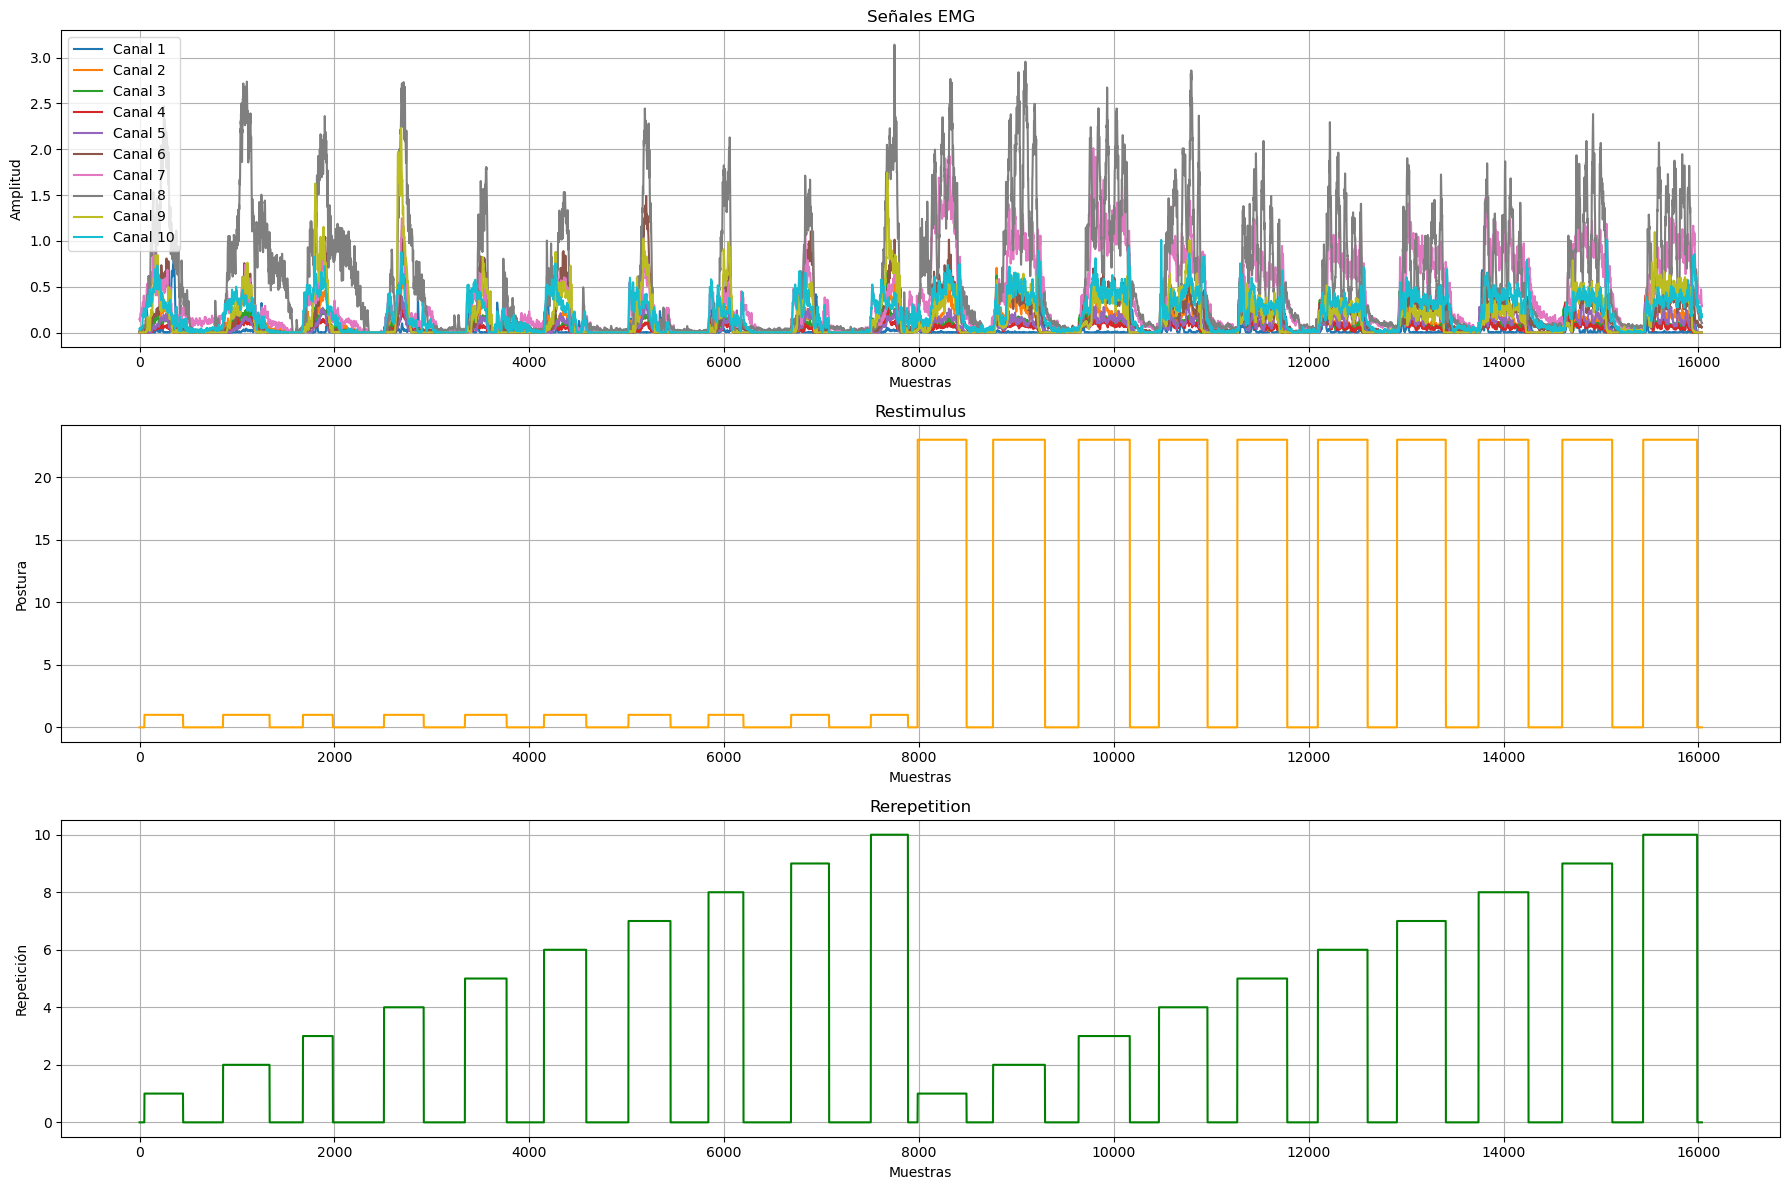

In [31]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1, color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1, color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [32]:
raw_data[INDEX_SUB].shape  # Mostrar la forma de los datos cargados

(16036, 12)

### EDA basico

Inicialmente vamos a juntar todo en un dataframe.

**To Do...** (Lo que sigue abajo es del dataframe viejo.)

#### Postura 1

#### Aplicación del procedimiento para todos los sujetos 

In [48]:
selected_exercises = [1, 23]  # Ejercicios seleccionados
data_for_selected_exercises = []
for subject in range(len(data)):
    data_for_selected_exercises.append(get_samples_by_exercises(data[subject], selected_exercises))
    # Obtener muestras de los ejercicios seleccionados para cada sujeto
    print(f"Sujeto {subject + 1}: {data_for_selected_exercises[subject].shape} muestras obtenidas para los ejercicios {selected_exercises}")

Sujeto 1: (16036, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 2: (15988, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 3: (16099, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 4: (15930, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 5: (16007, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 6: (15864, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 7: (15937, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 8: (16001, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 9: (16034, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 10: (15985, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 11: (16116, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 12: (15973, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 13: (15972, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 14: (16109, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 15: (16003, 12) muestr

In [49]:
len(data_for_selected_exercises)

27

In [50]:
data_for_selected_exercises[0].shape  # Mostrar la forma de los datos del primer sujeto

(16036, 12)

## Almacenamiento de los datos crudos a analizar

Los datos crudos a analizar se almacenarán en el directorio **`RAW_SUBSET_DATA_DIR`** siguiendo la nomenclatura `raw_subset_s{x}_p{1_2_*}_E3.npy`. Donde:
* **`s_{x}`**: Numero del sujeto.
* **`p_{nums}`**: Numero de las posturas seleccionadas.
* **`E3`**: Por que las posturas que se usan son las asociadas al ejercicio 3.

**Nota**: Se sobreentiende que la postura 0 va pues es asociada a la posición de descanso.

In [51]:
RAW_SUBSET_DATA_DIR

'c:\\Users\\Usuario\\Documents\\UdeA\\especializacion\\repos\\monografia\\data\\raw_subset'

In [52]:
selected_exercises

[1, 23]

In [53]:
# Crear el directorio si no existe
os.makedirs(RAW_SUBSET_DATA_DIR, exist_ok=True)

# Almacenar cada np.array en un archivo .npy
for idx, subject_data in enumerate(data_for_selected_exercises):
    file_name = f"raw_subset_s{idx + 1}_p{'_'.join(map(str, selected_exercises))}_E3.npy"
    file_path = os.path.join(RAW_SUBSET_DATA_DIR, file_name)
    np.save(file_path, subject_data)
    print(f"Archivo guardado: {file_path}")

Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s1_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s2_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s3_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s4_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s5_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s6_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s7_p1_23_E3.npy
Archivo guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw_subset\raw_subset_s8_p1_23

## Conclusiones

Al finalizar este notebook se logro.
* Almacena las posturas seleccionadas para los ejercicios 1 y 23 incluyendo los descansos